In [1]:
import os

os.chdir('../asr/')

In [2]:
import heapq

import torch
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import sentencepiece
import omegaconf

%reload_ext autoreload
%autoreload 2
from src.models import LASModel

NOTE! Installing ujson may make loading annotations faster.


## LAS: Listen Attend and Spell


### Dataset

In [3]:
DATA_PATH = '../asr/data'
TOKENIZER_PATH = '../asr/data/checkpoints_and_tokenizer/tokenizer/'
CKPT_PATH = '../asr/data/checkpoints_and_tokenizer/conformer_las_2epochs.ckpt'

In [4]:
df = pd.read_json(os.path.join(DATA_PATH, "test_opus/crowd/manifest.jsonl"), lines=True)

In [5]:
df.head()


,id,audio_filepath,text,duration
0,e632f7d39c15e7edfc665b91e6f2071f,files/e632f7d39c15e7edfc665b91e6f2071f.opus,афина воспроизведи музыку вперемешку,4.90000
1,5db5df8bb9e3b6660b2a04b34d4a355d,files/5db5df8bb9e3b6660b2a04b34d4a355d.opus,найти сериал григорий р,3.65200
2,2c471aedc6979109f28cd53c58f8c4fb,files/2c471aedc6979109f28cd53c58f8c4fb.opus,прямой эфир апл манчестер юнайтед тоттенхэм,4.34175
3,756a137ee9debde4a008adc4a4121dc7,files/756a137ee9debde4a008adc4a4121dc7.opus,ильвиром ивановичем ворончихиным,3.90000
4,1ee3b00170123a6723a40e129b2f6bce,files/1ee3b00170123a6723a40e129b2f6bce.opus,можешь показать киношку исходный код,3.32000


In [6]:
df.text.str.split().explode().value_counts().head(20)


на           1381
в            1253
включи        640
мне           603
у             588
фильм         482
смотрешке     459
тебя          459
афина         452
тв            432
сезон         419
джой          402
сбер          398
с             381
салют         376
есть          371
и             335
покажи        303
два           271
один          251
Name: text, dtype: int64

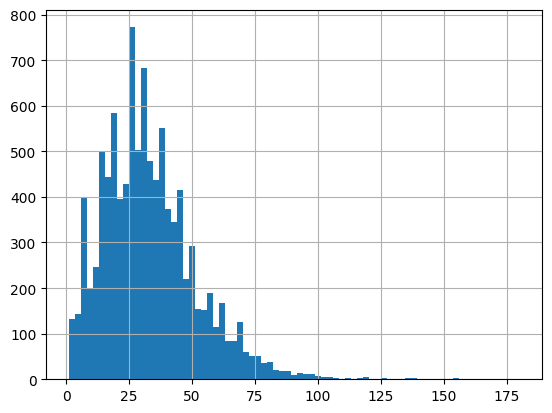

In [7]:
df.text.str.len().hist(bins=75);

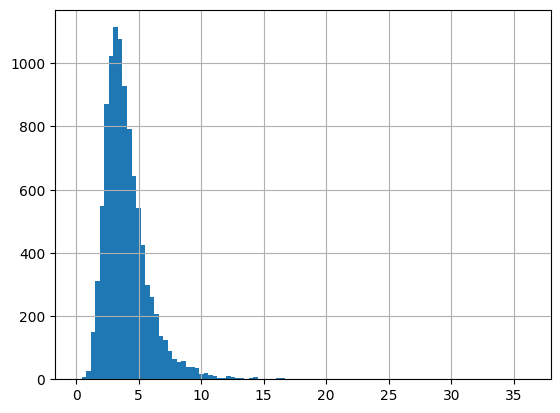

In [8]:
df.duration.hist(bins=100);


In [9]:
max(df.text.str.len() / df.duration)

24.39024390243902

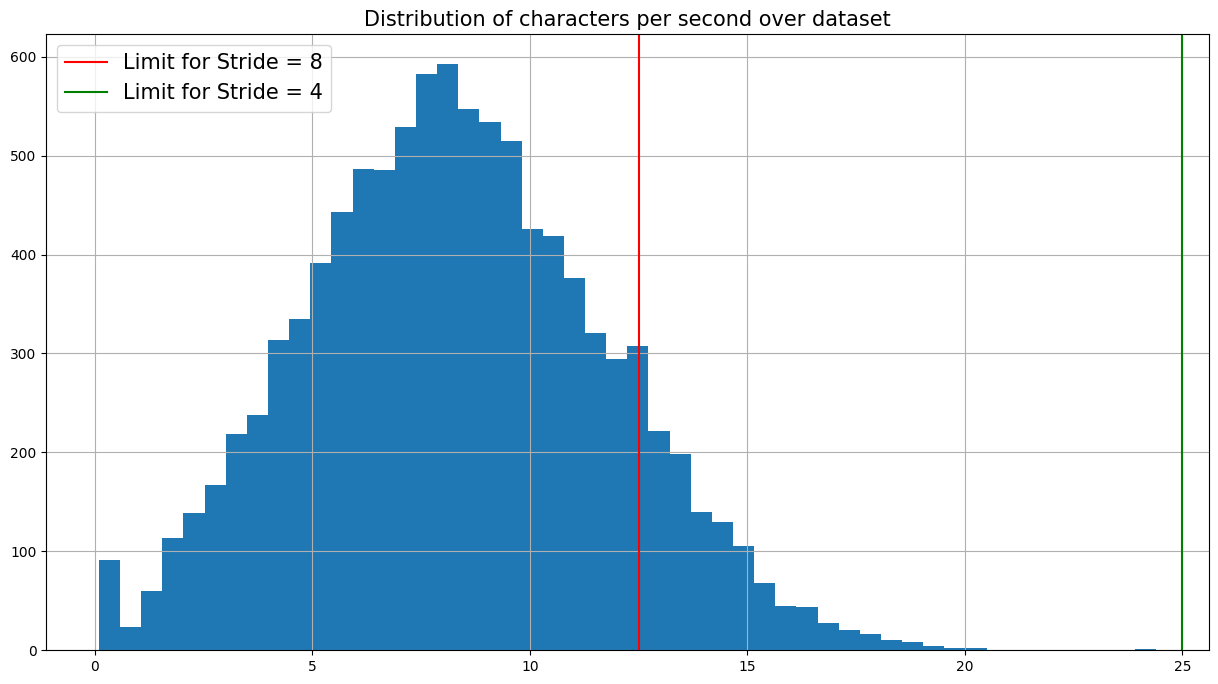

In [10]:
plt.figure(figsize=(15, 8))
(df.text.str.len() / df.duration).hist(bins=50);
plt.axvline(x=12.5, ymin=0, ymax=1.0, color='red', label='Limit for Stride = 8')
plt.axvline(x=25, ymin=0, ymax=1.0, color='green', label='Limit for Stride = 4')
plt.legend(fontsize=15)
plt.title('Distribution of characters per second over dataset', fontsize=15);

### Tokenizer

In [11]:
tokenizer = sentencepiece.SentencePieceProcessor(
    model_file=os.path.join(TOKENIZER_PATH, "bpe_1024_bos_eos.model")
)

In [12]:
tokenizer.encode_as_pieces('мама мыла раму')


['▁ма', 'ма', '▁м', 'ы', 'ла', '▁ра', 'му']

In [13]:
tokenizer.encode_as_ids('мама мыла раму')


[112, 119, 12, 1014, 55, 176, 304]

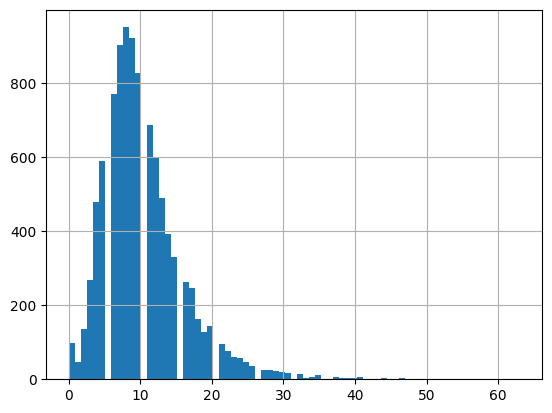

In [14]:
df.text.apply(lambda x: len(tokenizer.encode(x))).hist(bins=75);

In [15]:
tokens_per_second = df.text.apply(lambda x: len(tokenizer.encode(x))) / df.duration

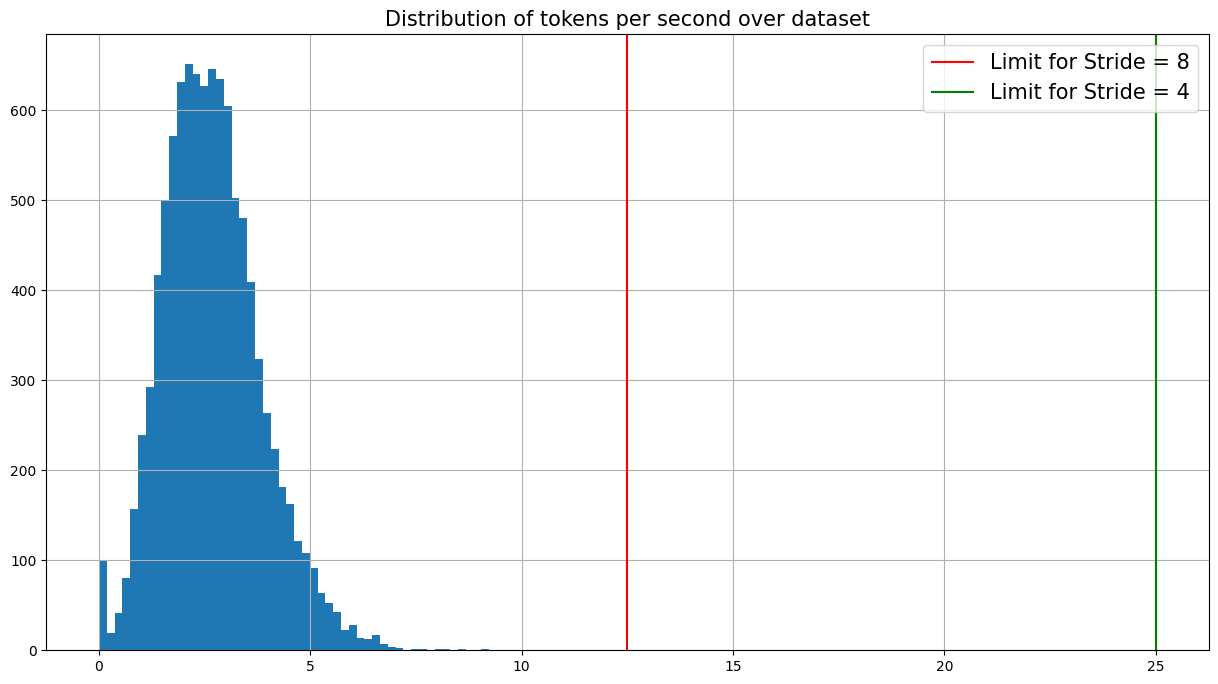

In [16]:
plt.figure(figsize=(15, 8))
tokens_per_second.hist(bins=50);
plt.axvline(x=12.5, ymin=0, ymax=1.0, color='red', label='Limit for Stride = 8')
plt.axvline(x=25, ymin=0, ymax=1.0, color='green', label='Limit for Stride = 4')
plt.legend(fontsize=15)
plt.title('Distribution of tokens per second over dataset', fontsize=15);

### model

In [17]:
conf = omegaconf.OmegaConf.load("./conf/conformer_las.yaml")
conf.train_dataloader.batch_size = 4
conf.train_dataloader.num_workers = 4

conf.model.decoder.tokenizer_path = os.path.join(TOKENIZER_PATH, "bpe_1024_bos_eos.model")


model = LASModel(conf=conf)
ckpt = torch.load(CKPT_PATH, map_location="cpu")
model.load_state_dict(ckpt)
model.eval()
model.freeze()

### features

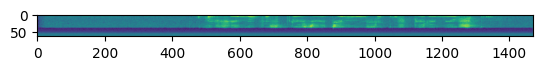

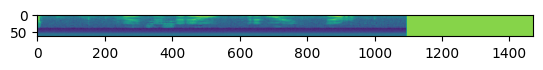

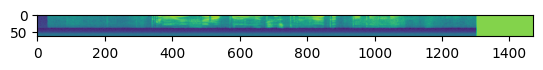

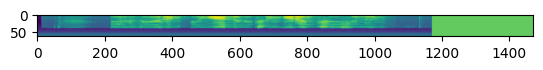

In [18]:


batch = next(iter(model.val_dataloader()))

features, features_len, targets, target_len = batch

for feature in features[0:4]:
    plt.imshow(feature)
    plt.show()

### loss

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5038: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/activation.py:1186: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at /opt/pytorch/pytorch/aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


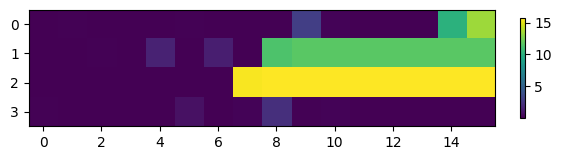

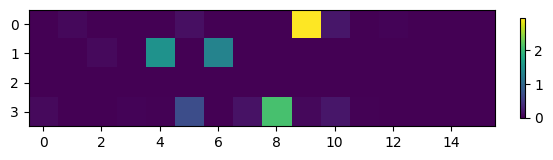

In [19]:
encoded, encoded_len = model(features, features_len)


encoded_pad_mask = model.make_pad_mask(encoded_len)

targets_outputs = targets[:, 1:] # without bos
targets_inputs = targets[:, :-1] # without eos / last pad token
target_len -= 1

target_pad_mask = model.make_pad_mask(target_len)
target_mask = model.make_attention_mask(target_len)

logits = model.decoder(encoded, ~encoded_pad_mask, targets_inputs, target_mask, ~target_pad_mask)

loss = model.loss(logits.transpose(1, 2), targets_outputs)
plt.imshow(loss)
plt.colorbar(fraction=0.01)
plt.show()
plt.imshow(loss * target_pad_mask)
plt.colorbar(fraction=0.01)
plt.show()

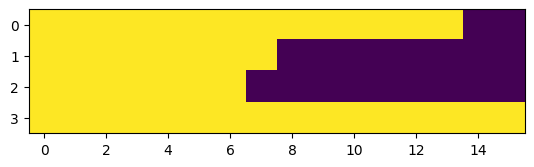

In [20]:
plt.imshow(target_pad_mask)


## Greedy Decoding

In [38]:
device = 'cuda:2' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

In [39]:
class GreedyDecoder:
    def __init__(self, model, tokenizer, max_steps=20):
        self.model = model
        self.max_steps = max_steps

    def __call__(self, encoded):
        
        tokens = [self.model.decoder.tokenizer.bos_id()]

        for _ in range(self.max_steps):
            
            tokens_batch = torch.tensor(tokens).unsqueeze(0)
            att_mask = self.model.make_attention_mask(torch.tensor([tokens_batch.size(-1)]))
            
            distribution = self.model.decoder(
                encoded=encoded.to(model.device), 
                encoded_pad_mask=None,
                target=tokens_batch.to(model.device), 
                target_mask=att_mask.to(model.device), 
                target_pad_mask=None
            )
        
            best_next_token = distribution[0, -1].argmax()
            
            if best_next_token == self.model.decoder.tokenizer.eos_id():
                break

            tokens.append(best_next_token.item())
        
        return self.model.decoder.tokenizer.decode(tokens)

In [42]:
conf.val_dataloader.batch_size = 5

batch = next(iter(model.val_dataloader()))

features, features_len, targets, target_len = batch

encoded, encoded_len = model(features.to(device), features_len.to(device))

In [43]:
decoder = GreedyDecoder(model, tokenizer)


for i in range(features.shape[0]):

    encoder_states = encoded[
        [i],
        :encoded_len[i],
        :
    ]
    
    ref_tokens = targets[i, :target_len[i]].tolist()
    
    print(f"reference : {tokenizer.decode(ref_tokens)}")
    print(f"hypothesis: {decoder(encoder_states)}")
    print("-" * 100 + '\n')

reference : афина воспроизведи музыку вперемешку
hypothesis: афина воспроизведи музыку в перемешку
----------------------------------------------------------------------------------------------------

reference : найти сериал григорий р
hypothesis: найти сериал григорьевый р
----------------------------------------------------------------------------------------------------

reference : прямой эфир апл манчестер юнайтед тоттенхэм
hypothesis: прямой эфир апл манчестер юнайтед тоттенхэм
----------------------------------------------------------------------------------------------------

reference : ильвиром ивановичем ворончихиным
hypothesis: ильвиром ивановичем баранчихиным
----------------------------------------------------------------------------------------------------

reference : можешь показать киношку исходный код
hypothesis: можешь показать киношку исходный код
----------------------------------------------------------------------------------------------------



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/activation.py:1186: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at /opt/pytorch/pytorch/aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


In [44]:
from src.metrics import WER

def compute_wer(refs, hyps):
    metric = WER()
    metric.update(refs, hyps)
    wer = metric.compute()
    return wer[0]

In [56]:
import gc
from tqdm import tqdm

conf.val_dataloader.batch_size = 200

batch = next(iter(model.val_dataloader()))
features, features_len, targets, target_len = batch
encoded, encoded_len = model(features.to(device), features_len.to(device))
hyps = []
refs = []

for i in tqdm(range(features.shape[0])):

    encoder_states = encoded[
        [i],
        :encoded_len[i],
        :
    ]
    
    ref_tokens = targets[i, :target_len[i]].tolist()
    refs.append(tokenizer.decode(ref_tokens))
    hyps.append(decoder(encoder_states))
    
gc.collect()
torch.cuda.empty_cache()

  0%|                                                                                                                                                                                                   | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/activation.py:1186: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at /opt/pytorch/pytorch/aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 46.94it/s]


In [57]:
print(f'WER: {"{:2.1f}".format(compute_wer(refs, hyps).item() * 100)}%')

WER: 23.1%


### Beam-search Decoding

In [84]:
class BeamSearchDecoder:
    
    def __init__(self, model, temp=1.0, beam_size=5, max_steps=20):
        self.model = model
        self.temp = temp
        self.beam_size = beam_size
        self.max_steps = max_steps
        
    def __call__(self, encoded):
        
        partial_hyps = [(0.0, [self.model.decoder.tokenizer.bos_id()])]
        final_hyps = []

        while len(final_hyps) < self.beam_size:
            
            # Берем лучшую гипотезу среди текущих partial-гипотез
            cur_partial_score, cur_partial_hyp = heapq.heappop(partial_hyps)
            
            tokens_batch = torch.tensor(cur_partial_hyp).unsqueeze(0)
            att_mask = self.model.make_attention_mask(torch.tensor([tokens_batch.size(-1)]))
            
            # Прогоняем ее через декодер и получаем логиты == кандидаты на расширение
            logits = self.model.decoder(
                encoded=encoded.to(self.model.device), 
                encoded_pad_mask=None,
                target=tokens_batch.to(self.model.device), 
                target_mask=att_mask.to(self.model.device), 
                target_pad_mask=None
            )

            logprobs = F.log_softmax(logits[0, -1] / self.temp, dim=-1)
            
            candidates = logprobs.topk(self.beam_size)
            
            # 
            for token_score, token_idx in zip(candidates.values, candidates.indices):
                
                token_idx = int(token_idx)

                new_score = cur_partial_score - float(token_score)
                new_hyp = cur_partial_hyp + [token_idx]
                new_item = (new_score, new_hyp)

                if token_idx == self.model.decoder.tokenizer.eos_id() or len(new_hyp) - 1 >= self.max_steps:
                    final_hyps.append(new_item)
                else:
                    heapq.heappush(partial_hyps, new_item)
            
            if len(partial_hyps) > self.beam_size:
                partial_hyps = heapq.nsmallest(self.beam_size, partial_hyps)
                heapq.heapify(partial_hyps)

        final_scores, final_token_lists = zip(*final_hyps)
        
        final_texts = [self.model.decoder.tokenizer.decode(final_token_list) for final_token_list in final_token_lists]


        result = list(zip(final_scores, final_texts))
        result.sort()

        return result[:self.beam_size]

In [59]:
decoder = BeamSearchDecoder(model, temp=1, beam_size=10)


for i in range(5):

    encoder_states = encoded[
        [i],
        :encoded_len[i],
        :
    ]
    
    ref_tokens = targets[i, :target_len[i]].tolist()
    
    print(f"reference   : {tokenizer.decode(ref_tokens)}")
    for k, (score, hyp) in enumerate(decoder(encoder_states)):
        print(f"hypothesis {k + 1}: {hyp} {score:.2f}")
    print("-" * 100 + '\n')

reference   : афина воспроизведи музыку вперемешку
hypothesis 1: афина воспроизведи музыку в перемешку 0.65
hypothesis 2: афина воспроизведи музыку в пельмешку 2.79
hypothesis 3: афина воспроизведи музыку в перемешку 3.27
hypothesis 4: афина воспроизведи музыку вперемешку 3.43
hypothesis 5: афина воспроизведе музыку в перемешку 3.53
hypothesis 6: афина воспроизведей музыку в перемешку 3.64
hypothesis 7: афина воспроизведи музыку в перемешку 3.80
hypothesis 8: афина воспроизведи музыку в перемешко 4.12
hypothesis 9: афина воспроизведи музыку в перемежку 4.63
hypothesis 10:  10.82
----------------------------------------------------------------------------------------------------

reference   : найти сериал григорий р
hypothesis 1: найти сериал григорий эр 2.14
hypothesis 2: найти сериал григорьи р 2.43
hypothesis 3: найти сериал григой эр 2.46
hypothesis 4: найти сериал григой р 2.69
hypothesis 5: найти сериал григорь 4.89
hypothesis 6: найти сериал григорьи 7.48
hypothesis 7: найти сер

In [123]:
import editdistance
import numpy as np

In [124]:
decoder = BeamSearchDecoder(model, temp=1, beam_size=20)

hyps = []
refs = []
oracle_hyps = []
best_hyp_indices = []

for i in tqdm(range(features.shape[0])):

    encoder_states = encoded[
        [i],
        :encoded_len[i],
        :
    ]
    
    ref_tokens = targets[i, :target_len[i]].tolist()
    refs.append(tokenizer.decode(ref_tokens))
    
    curr_hyps = decoder(encoder_states)
    hyps.append(curr_hyps[0][1])
    best_hyp_index = np.argmin([editdistance.eval(refs[-1].split(), hyp[1].split()) for hyp in curr_hyps])
    best_hyp_indices.append(best_hyp_index)
    
    oracle_hyp = curr_hyps[best_hyp_index]
    oracle_hyps.append(oracle_hyp[1])

gc.collect()
torch.cuda.empty_cache()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:27<00:00,  7.34it/s]


In [125]:
print(f'WER: {"{:2.1f}".format(compute_wer(refs, hyps).item() * 100)}%')

WER: 19.5%


In [126]:
print(f'Oracle WER: {"{:2.1f}".format(compute_wer(refs, oracle_hyps).item() * 100)}%')

Oracle WER: 10.1%
